In [1]:
# script to test basic functionality of gia package

import inversefed

import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from torchvision.utils import save_image
from utils.model_utils import ModelUtils
from torch.utils.data import DataLoader, Dataset


In [2]:
arch = 'ResNet18'
num_images = 10
trained_model = False
device = 'cuda'

In [19]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR10', defs)

mutils = ModelUtils(device="cuda")
model_bespoke = mutils.get_model("resnet10", "cifar10", "cuda")

model_control, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3)
model_control.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model_control.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model_control, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model_control.state_dict(), f'models/{file}')
model_control.eval();

Currently evaluating -------------------------------:
Sunday, 27. October 2024 04:25AM
CPUs: 20, GPUs: 4 on matlaber12.
GPU : NVIDIA GeForce GTX 1080 Ti
Files already downloaded and verified
Files already downloaded and verified
Model initialized with random key 3695468145.


In [4]:
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

In [5]:
num_images = 10
ground_truth, labels = [], []

for idx in range(num_images*3):
    img, label = validloader.dataset[idx]
    if label not in labels:
        labels.append(torch.as_tensor((label,), device=setup['device']))
        ground_truth.append(img.to(**setup))

ground_truth = torch.stack(ground_truth)
labels = torch.cat(labels)

ground_truth_target = ground_truth
labels_target = labels

In [54]:
# num_images = 1
# ground_truth_target, labels_target = [], []
# idx = 25 # choosen randomly ... just whatever you want
# while len(labels_target) < num_images:
#     img, label = validloader.dataset[idx]
#     idx += 1
#     if label not in labels_target:
#         labels_target.append(torch.as_tensor((label,), device=setup['device']))
#         ground_truth_target.append(img.to(**setup))
# ground_truth_target = torch.stack(ground_truth_target)
# labels_target = torch.cat(labels_target)

In [6]:
ground_truth.shape, labels.shape, ground_truth_target.shape, labels_target.shape

(torch.Size([10, 3, 32, 32]),
 torch.Size([10]),
 torch.Size([10, 3, 32, 32]),
 torch.Size([10]))

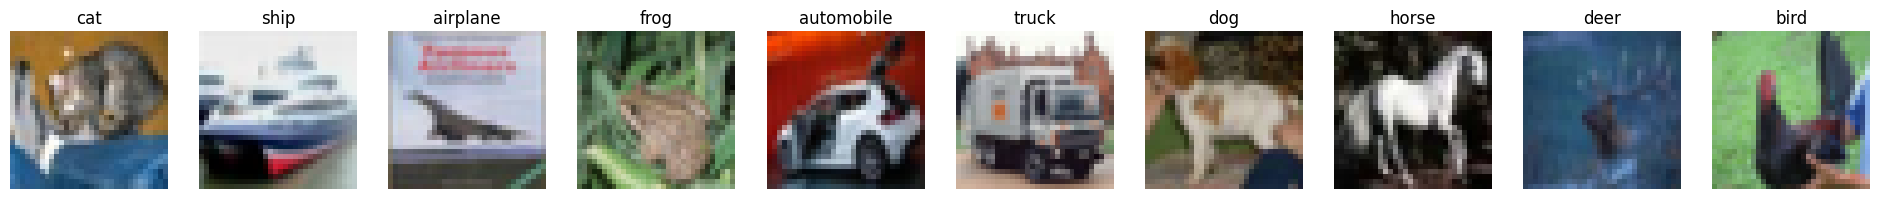

In [14]:
def grid_plot(tensor, labels):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)

    fig, axes = plt.subplots(1, 10, figsize=(24, 24))
    for im, l, ax in zip(tensor, labels, axes.flatten()):
        ax.imshow(im.permute(1, 2, 0).cpu());
        ax.set_title(l)
        ax.axis('off')

grid_plot(ground_truth, [validloader.dataset.classes[l] for l in labels])

In [6]:
local_lr = 3e-4
local_steps = 1
import pickle

from collections import OrderedDict
model_bespoke.zero_grad()
target_loss, _, _ = loss_fn(model_bespoke(ground_truth), labels)
input_parameters = inversefed.reconstruction_algorithms.loss_steps(model_bespoke, ground_truth, labels, 
                                                        lr=local_lr, local_steps=local_steps,
                                                                   use_updates=True)




# params_t = OrderedDict((name, param) for (name, param) in params_t_full[0].items() if name in params_s)
input_parameters = [p.detach() for p in input_parameters]

In [20]:
# based_model_names = [name for name, _ in model_bespoke.named_parameters()]
# with open ("start_reprs.pkl", 'rb') as f:
#     params_s_full = pickle.load(f)
# with open ("end_reprs.pkl", 'rb') as f:
#     params_t_full = pickle.load(f)
model_bespoke = mutils.get_model("resnet10", "cifar10", "cuda")
params_s = OrderedDict((name, param) for (name, param) in model_bespoke.named_parameters())
with open ("end_reprs.pkl", 'rb') as f:
    params_t_full = pickle.load(f)

params_t = OrderedDict((name, param) for (name, param) in params_t_full[0].items() if name in params_s)

In [21]:
param_diff = OrderedDict()
for (name_s, p_s), (name_t, p_t) in zip(params_s.items(), params_t.items()):
    if name_s == name_t:
        p_t = p_t.to(device)
        p_s = p_s.to(device)
        param_diff[name_s] = p_t - p_s

In [22]:
param_diff

OrderedDict([('conv1.weight',
              tensor([[[[-0.0006,  0.0561,  0.0613],
                        [-0.0925, -0.1245, -0.1912],
                        [ 0.2336, -0.0051,  0.0833]],
              
                       [[-0.0461,  0.0431,  0.1182],
                        [ 0.0759,  0.0499, -0.0546],
                        [-0.0938, -0.0426,  0.0995]],
              
                       [[-0.0867,  0.1786, -0.0268],
                        [-0.1879,  0.1099,  0.0997],
                        [ 0.0216, -0.0517,  0.0542]]],
              
              
                      [[[-0.0842, -0.0590, -0.0917],
                        [ 0.0528, -0.0941, -0.2365],
                        [-0.1343,  0.0125,  0.0060]],
              
                       [[-0.1608,  0.0795,  0.1789],
                        [ 0.0797, -0.0478,  0.1068],
                        [ 0.1370,  0.0267,  0.1973]],
              
                       [[-0.0459,  0.1254,  0.1123],
                        [-

In [7]:
import torch
from torch import nn
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Any

class CustomImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

def train_one_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: str
) -> Tuple[float, float]:
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(dataloader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Calculate loss
        loss = criterion(outputs, target)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track statistics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # Print batch statistics
        if batch_idx % 10 == 0:
            print(f'Batch: {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    return total_loss / len(dataloader), correct / total

# Main training setup
def main():
    # Model setup
    model_bespoke = mutils.get_model("resnet10", "cifar10", "cuda")
    model_bespoke.train()
    
    # Save initial parameters
    params_initial = OrderedDict((name, param.clone().detach()) 
                               for (name, param) in model_bespoke.named_parameters())
    
    # Optimizer setup
    optimizer = torch.optim.SGD(model_bespoke.parameters(), lr=3e-4, weight_decay=0)
    criterion = nn.CrossEntropyLoss()
    
    # Dataset setup (assuming ground_truth and labels are defined)
    dataset = CustomImageDataset(ground_truth, labels)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)
    
    # Training loop
    print("Starting training...")
    for epoch in range(1):
        loss, acc = train_one_epoch(model_bespoke, optimizer, dataloader, criterion, "cuda")
        print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')
    
    # Save final parameters and calculate differences
    params_final = OrderedDict((name, param.clone().detach()) 
                             for (name, param) in model_bespoke.named_parameters())
    
    # Calculate and print parameter differences
    param_diff = OrderedDict()
    for (name, p_initial), (_, p_final) in zip(params_initial.items(), params_final.items()):
        param_diff[name] = (p_final - p_initial)
    
    return model_bespoke, param_diff

if __name__ == "__main__":
    model, param_diff = main()

Starting training...
Batch: 0/1, Loss: 2.3967, Acc: 10.00%
Epoch: 1, Loss: 2.3967, Accuracy: 0.1000


In [9]:
param_diff

OrderedDict([('conv1.weight',
              tensor([[[[ 9.9093e-07, -4.6194e-07,  4.0047e-06],
                        [-1.0729e-06, -8.2254e-06, -2.9691e-06],
                        [-9.6262e-06, -1.4752e-05, -4.8131e-06]],
              
                       [[-4.6864e-06, -4.3809e-06, -1.7285e-06],
                        [-5.7071e-06, -1.0679e-05, -7.5102e-06],
                        [-1.4395e-05, -1.7047e-05, -8.5291e-06]],
              
                       [[-6.2361e-06, -5.7817e-06, -3.9898e-06],
                        [-6.8545e-06, -1.1079e-05, -7.0771e-06],
                        [-1.3404e-05, -1.5400e-05, -6.4522e-06]]],
              
              
                      [[[ 1.8328e-06,  6.0797e-06,  2.1458e-06],
                        [-1.0148e-05, -6.2585e-06, -2.6934e-06],
                        [-1.3158e-05, -9.8050e-06, -9.6485e-06]],
              
                       [[ 1.0267e-05,  1.5482e-05,  9.8795e-06],
                        [-2.4140e-06, -6.2585

In [8]:
input_parameters

[tensor([[[[ 1.3094e-06,  2.2575e-06,  9.5367e-07],
           [-3.5763e-07, -5.7369e-07, -1.7434e-06],
           [-1.3709e-06, -3.0920e-06, -3.6210e-06]],
 
          [[ 5.0340e-06,  5.3197e-06,  4.6045e-06],
           [ 2.2957e-06,  1.7583e-06,  7.5251e-07],
           [ 1.6615e-06, -4.3213e-07, -8.0466e-07]],
 
          [[ 1.4380e-06,  1.3784e-06,  1.5944e-06],
           [-1.5199e-06, -2.6003e-06, -2.5854e-06],
           [-1.8328e-06, -4.6492e-06, -4.3511e-06]]],
 
 
         [[[-4.0978e-06, -9.0785e-06, -7.7784e-06],
           [-1.8328e-06, -3.0994e-06, -4.8429e-07],
           [-1.9227e-06,  3.5604e-06,  6.3498e-06]],
 
          [[-3.7700e-06, -8.8876e-06, -8.1509e-06],
           [-5.2527e-07, -2.9840e-06, -2.8312e-07],
           [-3.0547e-06,  1.2964e-06,  3.2708e-06]],
 
          [[-3.4943e-06, -9.6448e-06, -7.7486e-06],
           [ 6.5565e-07, -3.5614e-06, -4.3213e-07],
           [-2.4363e-06, -7.0967e-07,  1.7583e-06]]],
 
 
         [[[ 2.6673e-05,  2.1972e-05,  1

In [10]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=8_000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.FedAvgReconstructor(model_bespoke, (dm, ds), 1, 3e-4, config,
                                             use_updates=True, num_images=num_images)
# output, stats = rec_machine.reconstruct(input_parameters, labels_target, img_shape=(3, 32, 32))


In [23]:
param_diff = [p.detach() for p in param_diff.values()]

In [32]:
labels_target

tensor([3, 8, 0, 6, 1, 9, 5, 7, 4, 2], device='cuda:0')

In [33]:
labels = torch.cat([torch.as_tensor((i,), device=setup['device']) for i in range(10)])
labels = labels.to(dtype=torch.float32)

In [34]:

output, stats = rec_machine.reconstruct(param_diff, labels=labels, img_shape=(3, 32, 32))

It: 0. Rec. loss: 1.0003.
It: 500. Rec. loss: 0.9900.
It: 1000. Rec. loss: 0.9899.
It: 1500. Rec. loss: 0.9898.
It: 2000. Rec. loss: 0.9898.
It: 2500. Rec. loss: 0.9897.
It: 3000. Rec. loss: 0.9900.
It: 3500. Rec. loss: 0.9892.
It: 4000. Rec. loss: 0.9890.
It: 4500. Rec. loss: 0.9890.
It: 5000. Rec. loss: 0.9891.
It: 5500. Rec. loss: 0.9889.
It: 6000. Rec. loss: 0.9889.
It: 6500. Rec. loss: 0.9890.
It: 7000. Rec. loss: 0.9890.
It: 7500. Rec. loss: 0.9890.
It: 7999. Rec. loss: 0.9890.
Choosing optimal result ...
Optimal result score: 0.9889
Total time: 616.5541167259216.


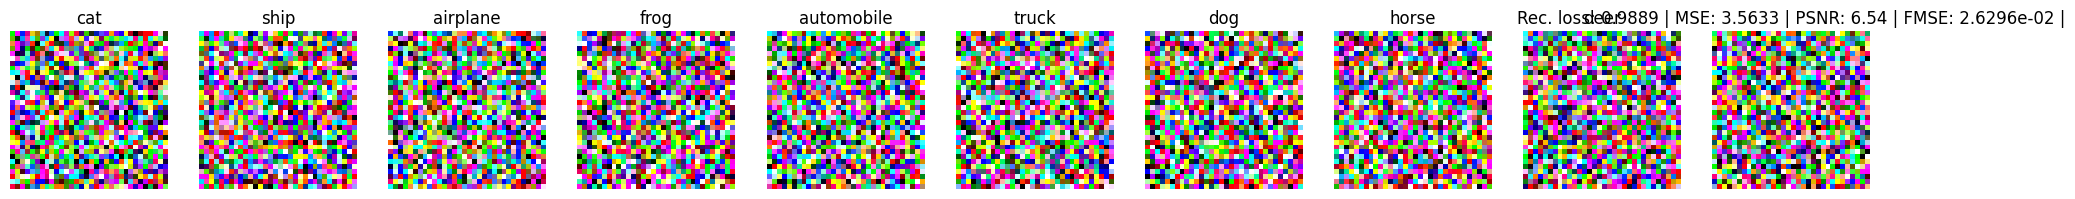

In [35]:
test_mse = (output.detach() - ground_truth_target).pow(2).mean()
feat_mse = (model_bespoke(output.detach())- model_bespoke(ground_truth_target)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth_target, factor=1/ds)

grid_plot(output, [validloader.dataset.classes[l] for l in labels_target])
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");